# COSMOS Trajectories

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import SparseCoder, DictionaryLearning

In [2]:
TYPES = ['Pedestrian', 'Cyclist', 'Pets']
CARRY_ONS = ['backpack', 'shoulder-bag', 'hand-bag', 'luggage', 'umbrella', 'misc']

In [26]:
X = np.load('custom1011_len21gs_fps2p5_balanced_train.npy')
v = np.load('custom1011_len21gs_fps2p5_balanced_valid.npy')
y = np.load('custom1011_len21gs_fps2p5_balanced_test.npy')
X.shape, v.shape, y.shape

((6177, 23, 9), (1556, 23, 9), (3219, 23, 9))

In [27]:
df = pd.DataFrame(
    X.reshape(-1, 9),
    columns=['scene', 'id', 'frame', 'label', 'x', 'y', 'w', 'h', 'curv']
)
df

,scene,id,frame,label,x,y,w,h,curv
0,26059.0,2.550416e+10,5.043931e+10,0.0,150.973595,300.523270,18.798850,35.750340,0.252097
1,26059.0,2.550416e+10,5.043931e+10,0.0,148.085075,305.839607,17.395530,33.192615,0.252097
2,26059.0,2.550416e+10,5.043931e+10,0.0,146.744388,314.889165,17.672065,34.972700,0.252097
3,26059.0,2.550416e+10,5.043931e+10,0.0,145.299975,317.007715,16.975150,33.256570,0.252097
4,26059.0,2.550416e+10,5.043931e+10,0.0,142.042978,321.549233,16.907635,32.067735,0.252097
...,...,...,...,...,...,...,...,...,...
142066,24150.0,1.275205e+10,5.043926e+10,1.0,359.464190,735.711395,55.612340,84.692330,0.756577
142067,24150.0,1.275205e+10,5.043926e+10,1.0,363.705315,756.626300,53.072370,84.349000,0.756577
142068,24150.0,1.275205e+10,5.043926e+10,1.0,367.758670,777.668217,51.059353,84.439127,0.756577
142069,24150.0,1.275205e+10,5.043926e+10,1.0,6.221679,500.895540,11.649972,46.265440,0.756577


## Dict

### Pos

In [33]:
X_obs = X[:, :9, [4, 5]]
X_prd = X[:, 9:21, [4, 5]]
v_obs = v[:, :9, [4, 5]]
v_prd = v[:, 9:21, [4, 5]]
X_obs.shape, X_prd.shape, v_obs.shape, v_prd.shape

((6177, 9, 2), (6177, 12, 2), (1556, 9, 2), (1556, 12, 2))

In [77]:
dim = 9 * 2
coder = SparseCoder(
     dictionary=X_obs[:1000].reshape(-1, dim), transform_algorithm='lasso_lars',
     transform_alpha=1e1,
)

In [78]:
x = coder.transform(v_obs.reshape(-1, dim))
x.shape

(1556, 1000)

In [79]:
def sci(x):
    # x -> [n, k]
    k = x.shape[1]
    l1 = np.linalg.norm(x, ord=1, axis=1)
    return (k * np.max(np.abs(x), axis=1) / l1 - 1) / (k - 1)

Text(0, 0.5, 'SCI')

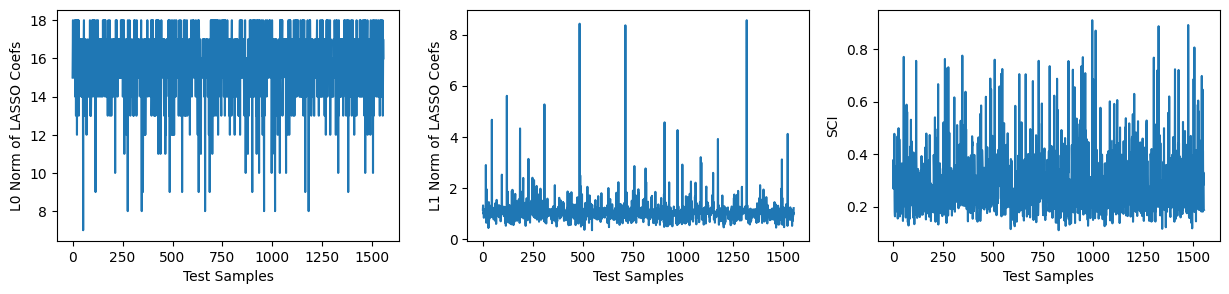

In [80]:
l0 = np.linalg.norm(x, ord=0, axis=1)
l1 = np.linalg.norm(x, ord=1, axis=1)
s = sci(x)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(l0)
ax[0].set_xlabel('Test Samples')
ax[0].set_ylabel('L0 Norm of LASSO Coefs')
ax[1].plot(l1)
ax[1].set_xlabel('Test Samples')
ax[1].set_ylabel('L1 Norm of LASSO Coefs')
ax[2].plot(s)
ax[2].set_xlabel('Test Samples')
ax[2].set_ylabel('SCI')

(-0.5, 831.5, 831.5, -0.5)

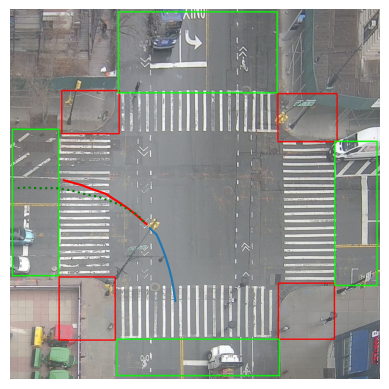

In [103]:
i = 500
ids = np.argsort(x[i])[::-1][:100]
c = np.linalg.norm(x[i, ids], ord=2) / np.linalg.norm(x[i], ord=2)
prd = np.dot(X_prd[ids].transpose(1, 2, 0), x[i, ids] / c)
img = plt.imread('test_boxes.jpg')
plt.imshow(img)
plt.plot(v_obs[i, :, 0], v_obs[i, :, 1])
plt.plot(prd[:, 0], prd[:, 1], 'r')
plt.plot(v_prd[i, :, 0], v_prd[i, :, 1], 'g:')
plt.axis('off')

### Vel

In [104]:
X_obs = X[:, :9, [4, 5]]
X_obs_v = X[:, 1:9, [4, 5]] - X[:, 0:8, [4, 5]]
X_prd = X[:, 9:21, [4, 5]]
v_obs = v[:, :9, [4, 5]]
v_obs_v = v[:, 1:9, [4, 5]] - v[:, 0:8, [4, 5]]
v_prd = v[:, 9:21, [4, 5]]
X_obs.shape, X_obs_v.shape, X_prd.shape, v_obs.shape, v_obs_v.shape, v_prd.shape

((6177, 9, 2),
 (6177, 8, 2),
 (6177, 12, 2),
 (1556, 9, 2),
 (1556, 8, 2),
 (1556, 12, 2))

In [106]:
dim = 8 * 2
coder = SparseCoder(
     dictionary=X_obs_v[:1000].reshape(-1, dim), transform_algorithm='lasso_lars',
     transform_alpha=1e1,
)

In [107]:
x = coder.transform(v_obs_v.reshape(-1, dim))
x.shape

(1556, 1000)

In [108]:
def sci(x):
    # x -> [n, k]
    k = x.shape[1]
    l1 = np.linalg.norm(x, ord=1, axis=1)
    return (k * np.max(np.abs(x), axis=1) / l1 - 1) / (k - 1)

/tmp/ipykernel_738610/3135054564.py:5: RuntimeWarning: invalid value encountered in divide
  return (k * np.max(np.abs(x), axis=1) / l1 - 1) / (k - 1)


Text(0, 0.5, 'SCI')

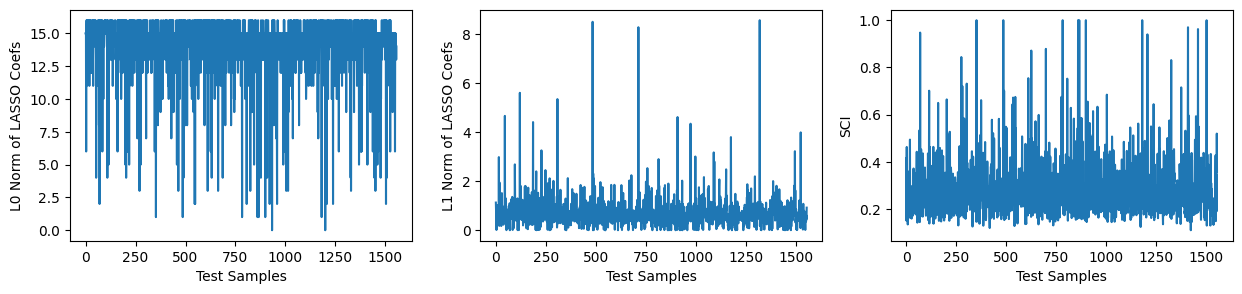

In [109]:
l0 = np.linalg.norm(x, ord=0, axis=1)
l1 = np.linalg.norm(x, ord=1, axis=1)
s = sci(x)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(l0)
ax[0].set_xlabel('Test Samples')
ax[0].set_ylabel('L0 Norm of LASSO Coefs')
ax[1].plot(l1)
ax[1].set_xlabel('Test Samples')
ax[1].set_ylabel('L1 Norm of LASSO Coefs')
ax[2].plot(s)
ax[2].set_xlabel('Test Samples')
ax[2].set_ylabel('SCI')

(-0.5, 831.5, 831.5, -0.5)

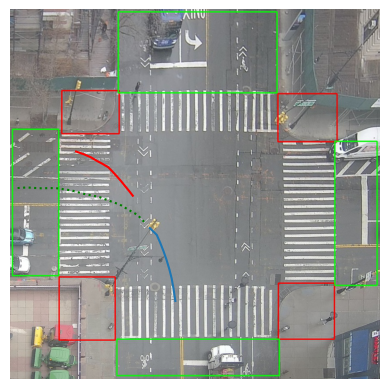

In [114]:
i = 500
ids = np.argsort(x[i])[::-1][:100]
c = np.linalg.norm(x[i, ids], ord=2) / np.linalg.norm(x[i], ord=2)
prd = np.dot(X_prd[ids].transpose(1, 2, 0), x[i, ids] / c)
img = plt.imread('test_boxes.jpg')
plt.imshow(img)
plt.plot(v_obs[i, :, 0], v_obs[i, :, 1])
plt.plot(prd[:, 0], prd[:, 1], 'r')
plt.plot(v_prd[i, :, 0], v_prd[i, :, 1], 'g:')
plt.axis('off')

### Pos + Vel

In [117]:
X_obs_pv = np.concatenate([X_obs, X_obs_v], axis=1)
v_obs_pv = np.concatenate([v_obs, v_obs_v], axis=1)
X_obs_pv.shape, v_obs_pv.shape

((6177, 17, 2), (1556, 17, 2))

In [118]:
dim = 17 * 2
coder = SparseCoder(
     dictionary=X_obs_pv[:1000].reshape(-1, dim), transform_algorithm='lasso_lars',
     transform_alpha=1e1,
)

In [119]:
x = coder.transform(v_obs_pv.reshape(-1, dim))
x.shape

(1556, 1000)

In [120]:
def sci(x):
    # x -> [n, k]
    k = x.shape[1]
    l1 = np.linalg.norm(x, ord=1, axis=1)
    return (k * np.max(np.abs(x), axis=1) / l1 - 1) / (k - 1)

Text(0, 0.5, 'SCI')

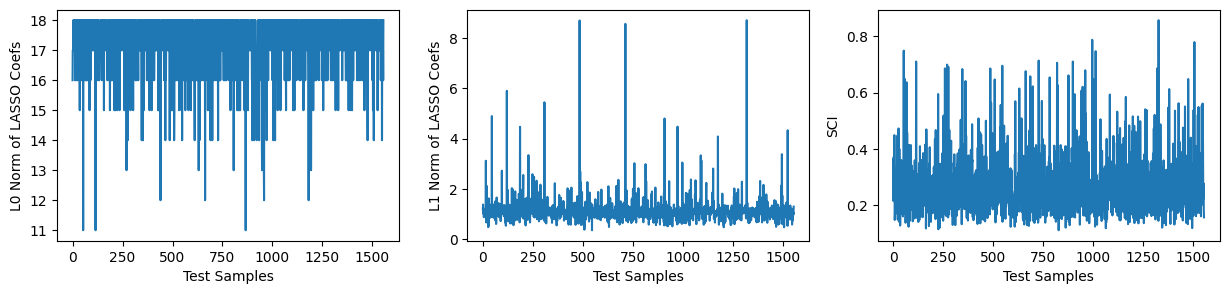

In [121]:
l0 = np.linalg.norm(x, ord=0, axis=1)
l1 = np.linalg.norm(x, ord=1, axis=1)
s = sci(x)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(l0)
ax[0].set_xlabel('Test Samples')
ax[0].set_ylabel('L0 Norm of LASSO Coefs')
ax[1].plot(l1)
ax[1].set_xlabel('Test Samples')
ax[1].set_ylabel('L1 Norm of LASSO Coefs')
ax[2].plot(s)
ax[2].set_xlabel('Test Samples')
ax[2].set_ylabel('SCI')

(-0.5, 831.5, 831.5, -0.5)

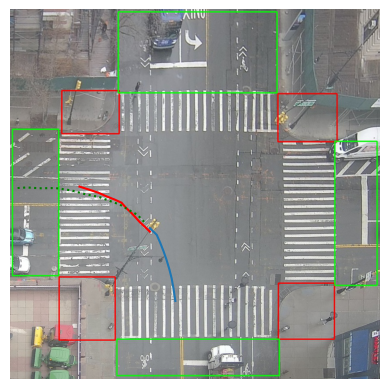

In [125]:
i = 500
ids = np.argsort(x[i])[::-1][:8]
c = np.linalg.norm(x[i, ids], ord=2) / np.linalg.norm(x[i], ord=2)
prd = np.dot(X_prd[ids].transpose(1, 2, 0), x[i, ids] / c)
img = plt.imread('test_boxes.jpg')
plt.imshow(img)
plt.plot(v_obs[i, :, 0], v_obs[i, :, 1])
plt.plot(prd[:, 0], prd[:, 1], 'r')
plt.plot(v_prd[i, :, 0], v_prd[i, :, 1], 'g:')
plt.axis('off')